In [1192]:
import pandas as pd

In [1193]:
df = pd.read_csv('./new_data/train.csv')

In [1194]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


# НАЧИНАЕМ С ОЧЕВИДНОГО

In [1196]:
len(df) - len(df.drop_duplicates('id', keep=False))

0

### id записей ни разу не повторяются, не значащие -> с ними трудно найти зависимость, можно убрать

In [1198]:
df = df.drop(columns=['id'])

### В тесте нет данного признака (т.к. это время старта + таргет), соответственно убираем

In [1200]:
df = df.drop(columns=['dropoff_datetime'])

### Пассажиров не может быть ноль

In [1202]:
df['passenger_count'].min()

0

In [1203]:
df = df[df['passenger_count']>0]

# ПРОВЕРЯЕМ НА ПРОПУСКИ

In [1205]:
df.isna().sum()

vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Их нет!

# РАЗБИРАЕМСЯ С СЕТКОЙ

In [1208]:
import folium
import datetime
import math

### Посмотрим, как ситуация с распределением координат

In [1210]:
df.drop(columns=['vendor_id', 'passenger_count', 'trip_duration']).describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.021009e+06,1.021009e+06,1.021009e+06,1.021009e+06
mean,-7.397347e+01,4.075093e+01,-7.397339e+01,4.075180e+01
std,6.453977e-02,3.347311e-02,6.416129e-02,3.581501e-02
min,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01
25%,-7.399187e+01,4.073734e+01,-7.399132e+01,4.073587e+01
50%,-7.398175e+01,4.075411e+01,-7.397975e+01,4.075453e+01
75%,-7.396734e+01,4.076834e+01,-7.396303e+01,4.076981e+01
max,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01


### Есть координаты очень далеко от фактических Манхэттенских. Почистим места старта для создания сетки и посмотрим ещё раз

In [1212]:
col_names = ['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude']
df_c = df
for col in col_names:
  q1 = df_c[col].quantile(0.001)
  q3 = df_c[col].quantile(0.999)
  df_c = df_c[(df_c[col] >= q1) & (df_c[col] <= q3)]

In [1213]:
df_c.drop(columns=['vendor_id', 'passenger_count', 'trip_duration']).describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.012973e+06,1.012973e+06,1.012973e+06,1.012973e+06
mean,-7.397394e+01,4.075116e+01,-7.397362e+01,4.075192e+01
std,3.682191e-02,2.726459e-02,3.329131e-02,3.103228e-02
min,-7.401717e+01,4.064150e+01,-7.417746e+01,4.060655e+01
25%,-7.399188e+01,4.073757e+01,-7.399130e+01,4.073620e+01
50%,-7.398180e+01,4.075421e+01,-7.397980e+01,4.075461e+01
75%,-7.396758e+01,4.076835e+01,-7.396326e+01,4.076976e+01
max,-7.377670e+01,4.084287e+01,-7.375323e+01,4.088700e+01


### Больше похоже на правду. Теперь построим сетку для визуального понимания с помощью folium

In [1215]:
min_lat = df_c[['pickup_latitude', 'dropoff_latitude']].min().min()
max_lat = df_c[['pickup_latitude', 'dropoff_latitude']].max().max()+0.0001 # это делаем, чтобы дальше было проще считать клетку
min_lon = df_c[['pickup_longitude', 'dropoff_longitude']].min().min()
max_lon = df_c[['pickup_longitude', 'dropoff_longitude']].max().max()+0.0001

In [1216]:
grid_size = 3

lat_step = (max_lat-min_lat)/grid_size
lon_step = (max_lon-min_lon)/grid_size

def create_grid(north, south, east, west):
    grid = []
    for i in range(grid_size):
        for j in range(grid_size):
            lat1 = north - i*lat_step
            lat2 = north - (i+1)*lat_step
            lon1 = west + j*lon_step
            lon2 = west + (j+1)*lon_step
            grid.append([[lat1, lon1], [lat1, lon2], [lat2, lon2], [lat2, lon1], [lat1, lon1]])
    return grid

grid = create_grid(max_lat, min_lat, max_lon, min_lon)

In [1217]:
map_manhattan = folium.Map(location = [40.7445, -73.9712], zoom_start = 11)

for cell in grid:
    folium.Polygon(locations=cell, color= "blue", fill=True, fill_opacity=0.1).add_to(map_manhattan)

In [1218]:
map_manhattan

### Ну в принципе неплохое деление. Пронумеруем колонки слева направо снизу вверх от 1 до 9. Выбросные колонки будем кодировать 10-кой

In [1220]:
def calc_cell(lon, lat):
    lon_cell = math.floor((lon - min_lon)/lon_step)+1
    lat_cell = math.floor((lat - min_lat)/lat_step)
    ret_cell = lon_cell + lat_cell*grid_size
    if (ret_cell < 1 or ret_cell > 9):
        ret_cell = 10
    return ret_cell

In [1221]:
df['pickup_cell'] = df.apply(lambda row: calc_cell(row.pickup_longitude, row.pickup_latitude), axis=1)
df['dropoff_cell'] = df.apply(lambda row: calc_cell(row.dropoff_longitude, row.dropoff_latitude), axis=1)

In [1222]:
df['pickup_cell'].unique()

array([ 5,  8,  3,  2,  6, 10,  9,  1,  4,  7], dtype=int64)

In [1223]:
df['dropoff_cell'].unique()

array([ 5,  6,  1,  2,  8, 10,  3,  9,  4,  7], dtype=int64)

### Найдём самую популярную пару значений

In [1225]:
pair_counts = df.groupby(['pickup_cell', 'dropoff_cell']).size().reset_index(name='counts')
pair_counts[pair_counts['counts'] == pair_counts['counts'].max()]

,pickup_cell,dropoff_cell,counts
37,5,5,830312


### Неудивительно, по центру города ездит больше всего народа. Создадим отдельную колонку для самого популярного маршрута

In [1227]:
df['popular_route'] = df.apply(lambda row: int(row.pickup_cell == 5 and row.dropoff_cell == 5), axis=1)

# ИЗВЛЕКАЕМ ДРУГИЕ ФИЧИ

In [1229]:
import seaborn as sns

### Разбор даты-времени. Т.к. зависимость скорее всего нелинейная, попробуем поделить неделю и сутки на части

In [1231]:
# df['year'] = df['pickup_datetime'].str[:4] - оказалось бесполезно, т.к. df['year'].unique() выдаёт только 2016

# Добавляем месяц
df['month'] = df['pickup_datetime'].str[5:7].astype(int)
# Добавляем день недели
df['dow'] = df['pickup_datetime'].apply(lambda timestamp: datetime.date(day=int(timestamp[8:10]), month=int(timestamp[5:7]), year=int(timestamp[:4])).weekday())
# Добавляем деление на части недели
df['corner_days'] = df.apply(lambda row: int(row.dow in [0,4]), axis=1)
df['middle_days'] = df.apply(lambda row: int(row.dow in [1,2,3]), axis=1)
df['weekends'] = df.apply(lambda row: int(row.dow in [5,6]), axis=1)
# Добавляем час
df['hour'] = df['pickup_datetime'].str[10:13].astype(int)
# Добавляем деление на части дня
df['morning'] = df.apply(lambda row: int(row.hour >= 5 and row.hour <= 12), axis=1)
df['day'] = df.apply(lambda row: int(row.hour >= 13 and row.hour <= 17), axis=1)
df['evening'] = df.apply(lambda row: int(row.hour >= 18 and row.hour <= 22), axis=1)
df['night'] = df.apply(lambda row: int(row.hour >= 23 or row.hour <= 4 ), axis=1)

### Считаем Манхеттенское расстояние в километрах - по сути "лесенку", учитывающую кварталы

In [1233]:
def calc_manhattan(lat1, lat2, lon1, lon2):
    return (abs(lat2-lat1) + abs(lon2-lon1))*111

df['manhattan'] = df.apply(lambda row: calc_manhattan(row.pickup_latitude, row.dropoff_latitude, row.pickup_longitude, row.dropoff_longitude), axis=1)

### Считаем расстояние по Хаверсину в километрах - расстояние "напрямую" по поверхности земного шара

In [1235]:
def calc_haversine(lat1, lat2, lon1, lon2):
    R = 6371e3;
    phi1 = lat1 * math.pi/180;
    phi2 = lat2 * math.pi/180;
    dphi = (lat2-lat1) * math.pi/180;
    dlam = (lon2-lon1) * math.pi/180;

    a = math.sin(dphi/2) * math.sin(dphi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(dlam/2) * math.sin(dlam/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));

    return (R * c)/1000

df['haversine'] = df.apply(lambda row: calc_haversine(row.pickup_latitude, row.dropoff_latitude, row.pickup_longitude, row.dropoff_longitude), axis=1)

### Убираем использованные данные

In [1237]:
df = df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

In [1238]:
df.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup_cell,dropoff_cell,popular_route,month,dow,corner_days,middle_days,weekends,hour,morning,day,evening,night,manhattan,haversine
0,2,2,N,844,5,5,1,5,1,0,1,0,9,1,0,0,0,1.556110,1.263187
1,1,1,N,1001,5,5,1,1,4,1,0,0,16,0,1,0,0,5.754856,4.804012
2,1,1,N,1048,5,6,0,4,6,0,0,1,13,0,1,0,0,10.918602,7.471088
3,2,1,N,784,5,5,1,1,6,0,0,1,17,0,1,0,0,4.241936,3.444869
4,1,1,N,732,5,5,1,2,3,0,1,0,17,0,1,0,0,3.395073,2.481063


### Перед чисткой смотрим на корреляцию

<Axes: >

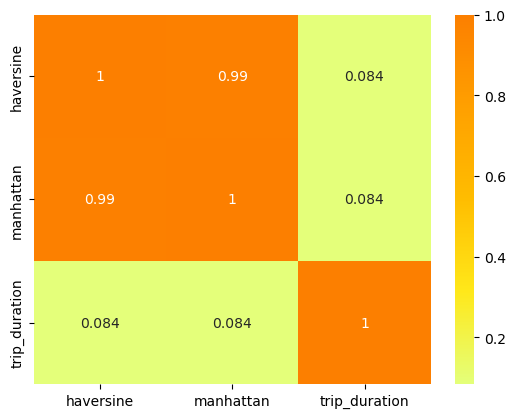

In [1240]:
corr_matrix = df[['haversine', 'manhattan', 'trip_duration']].corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='Wistia', annot=True)

# ЧИСТИМ РАССТОЯНИЕ И ТАРГЕТ ОТ ВЫБРОСОВ

In [1242]:
import numpy as np
import matplotlib.pyplot as plt

### Подберём квантили для максимизации корреляции между таргетом и Хаверсином. Вручную было получено, что она лучше при тысячных, конкретные значения подбираем.

### Причина выбора Хаверсина: дальнейшие опыты показали, что даже при обрезании по Манхэттэнскому расстоянию предсказания чисто по Хаверсину всё равно лучше

In [1023]:
# Функция для фильтрации выбросов на основе квантилей
def filter_outliers(df, quantiles_col1, quantiles_col2):
    q1_low, q1_high = quantiles_col1
    q2_low, q2_high = quantiles_col2
    
    df_filtered = df[
        (df['haversine'] >= df['haversine'].quantile(q1_low)) & 
        (df['haversine'] <= df['haversine'].quantile(q1_high)) & 
        (df['trip_duration'] >= df['trip_duration'].quantile(q2_low)) & 
        (df['trip_duration'] <= df['trip_duration'].quantile(q2_high))
    ]
    return df_filtered

# Поиск максимальной корреляции
best_corr = -1
best_quantiles = None

for q1_low in np.arange(0, 0.01, 0.001):
    for q1_high in np.arange(0.99, 1, 0.001):
        for q2_low in np.arange(0, 0.01, 0.001):
            for q2_high in np.arange(0.99, 1, 0.001):
                # Фильтруем данные на основе квантилей
                df_filtered = filter_outliers(df, (q1_low, q1_high), (q2_low, q2_high))
                # Вычисляем корреляцию
                corr = df_filtered['haversine'].corr(df_filtered['trip_duration'])
                # Обновляем лучший результат
                if corr > best_corr:
                    best_corr = corr
                    best_quantiles = ((q1_low, q1_high), (q2_low, q2_high))

print(f'Максимальная корреляция: {best_corr}')
print(f'Лучшие квантили для Хаверсина: {best_quantiles[0]}')
print(f'Лучшие квантили для Времени поездки: {best_quantiles[1]}')

# Лишний раз лучше эту штуку не запускать. Копия результатов:
"""  Максимальная корреляция: 0.7751991617293412
Лучшие квантили для Хаверсина: (0.009000000000000001, 0.999)
Лучшие квантили для Времени поездки: (0.0, 0.998) """

Максимальная корреляция: 0.7751991617293412
Лучшие квантили для Хаверсина: (0.009000000000000001, 0.999)
Лучшие квантили для Времени поездки: (0.0, 0.998)


### Посмотрим, как изменится распределение расстояния после обрезания

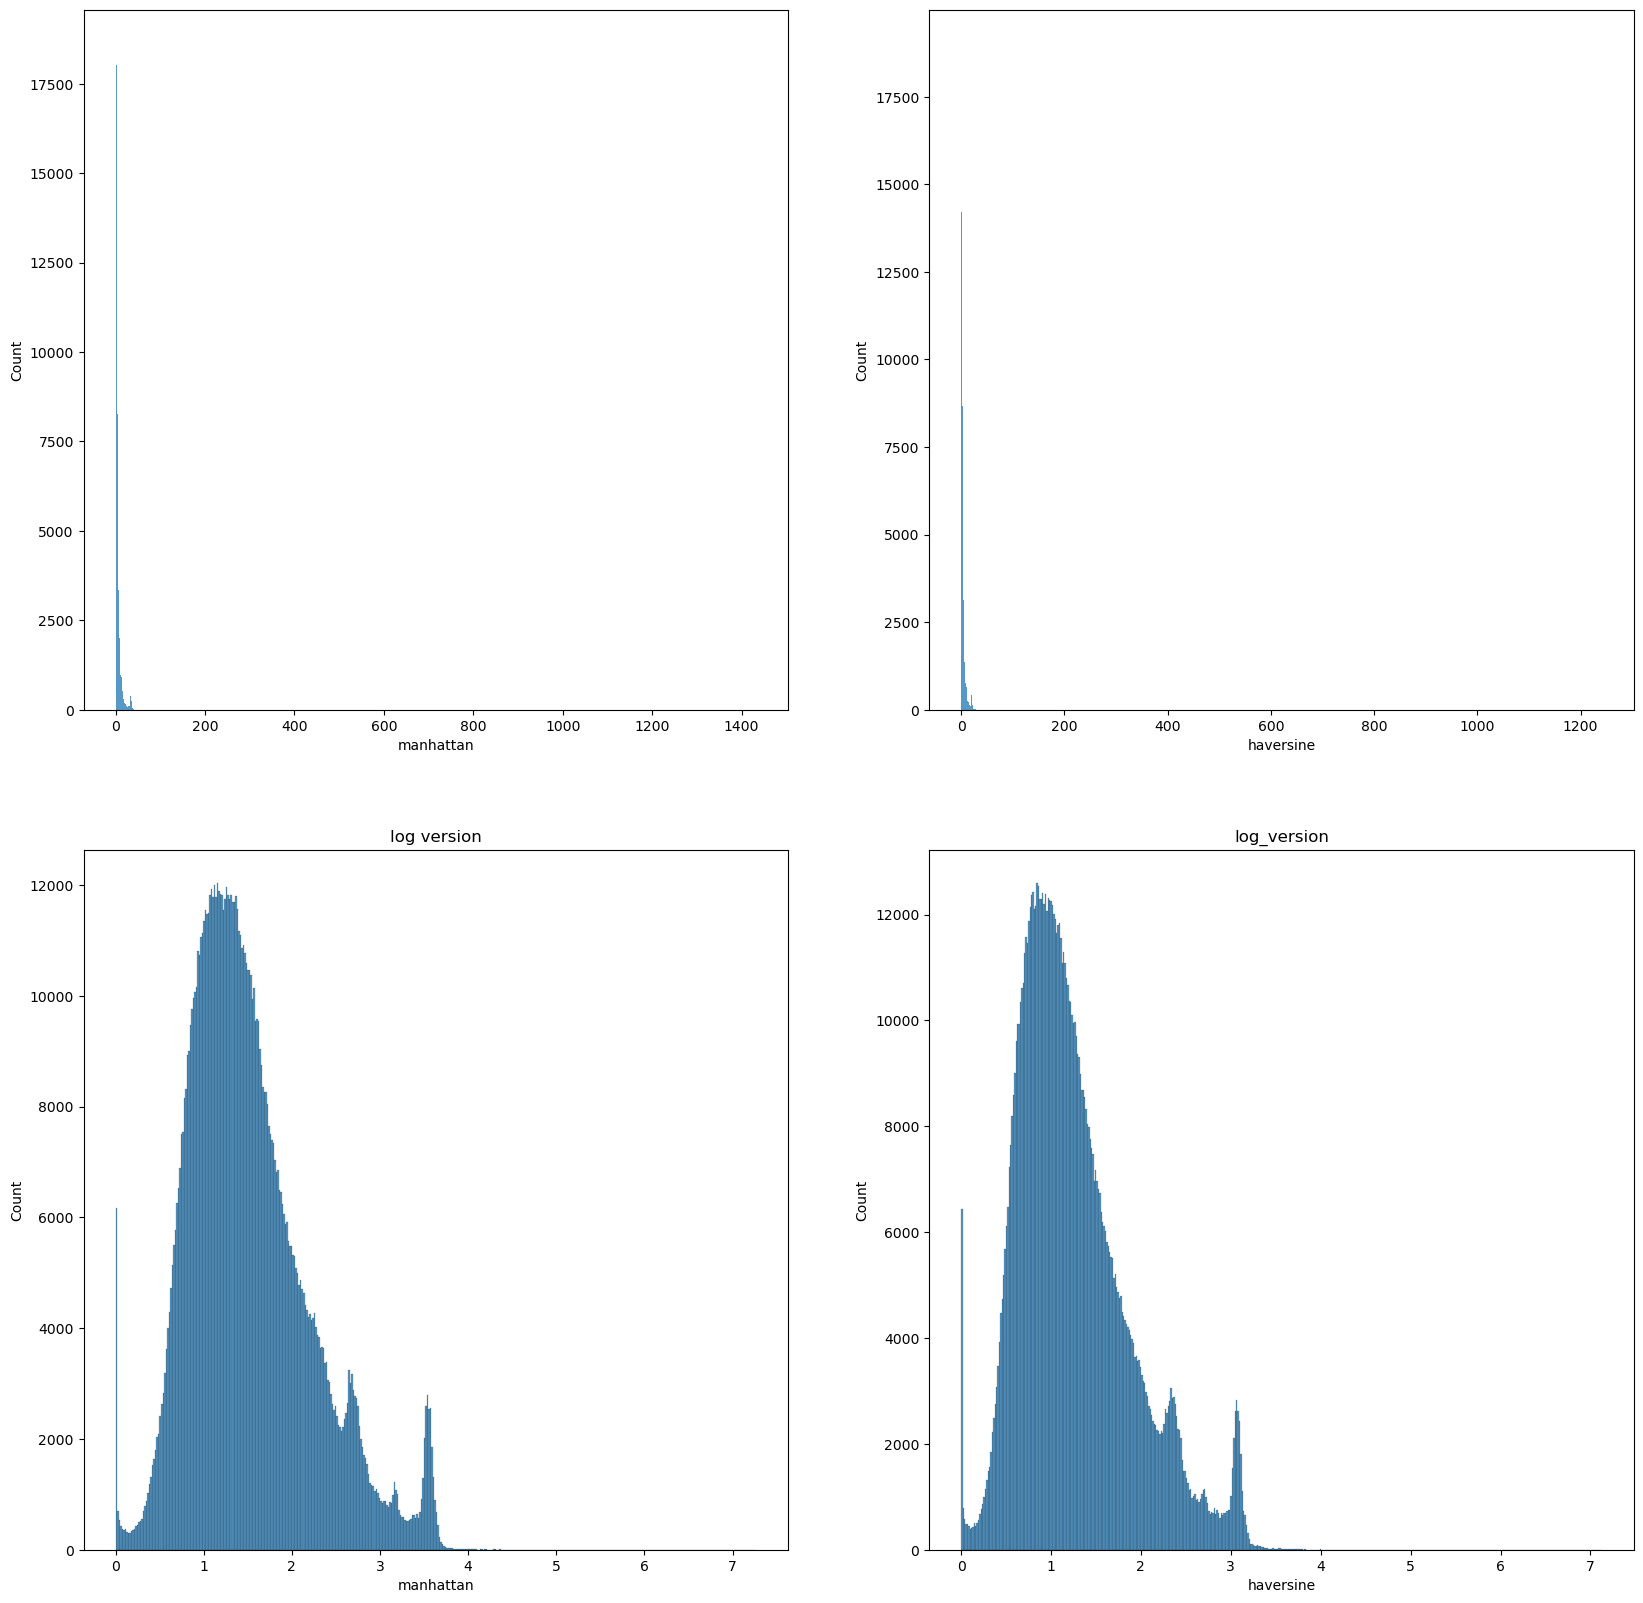

In [1277]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.histplot(df['manhattan'])

plt.subplot(2, 2, 2)
sns.histplot(df['haversine'])


plt.subplot(2, 2, 3)
sns.histplot(np.log1p(df['manhattan']))
plt.title('log version')

plt.subplot(2, 2, 4)
sns.histplot(np.log1p(df['haversine']))
plt.title('log_version')

plt.show()

In [1278]:
q1 = df['haversine'].quantile(0.009)
q3 = df['haversine'].quantile(0.999)
df = df[(df['haversine'] >= q1) & (df['haversine'] <= q3)]

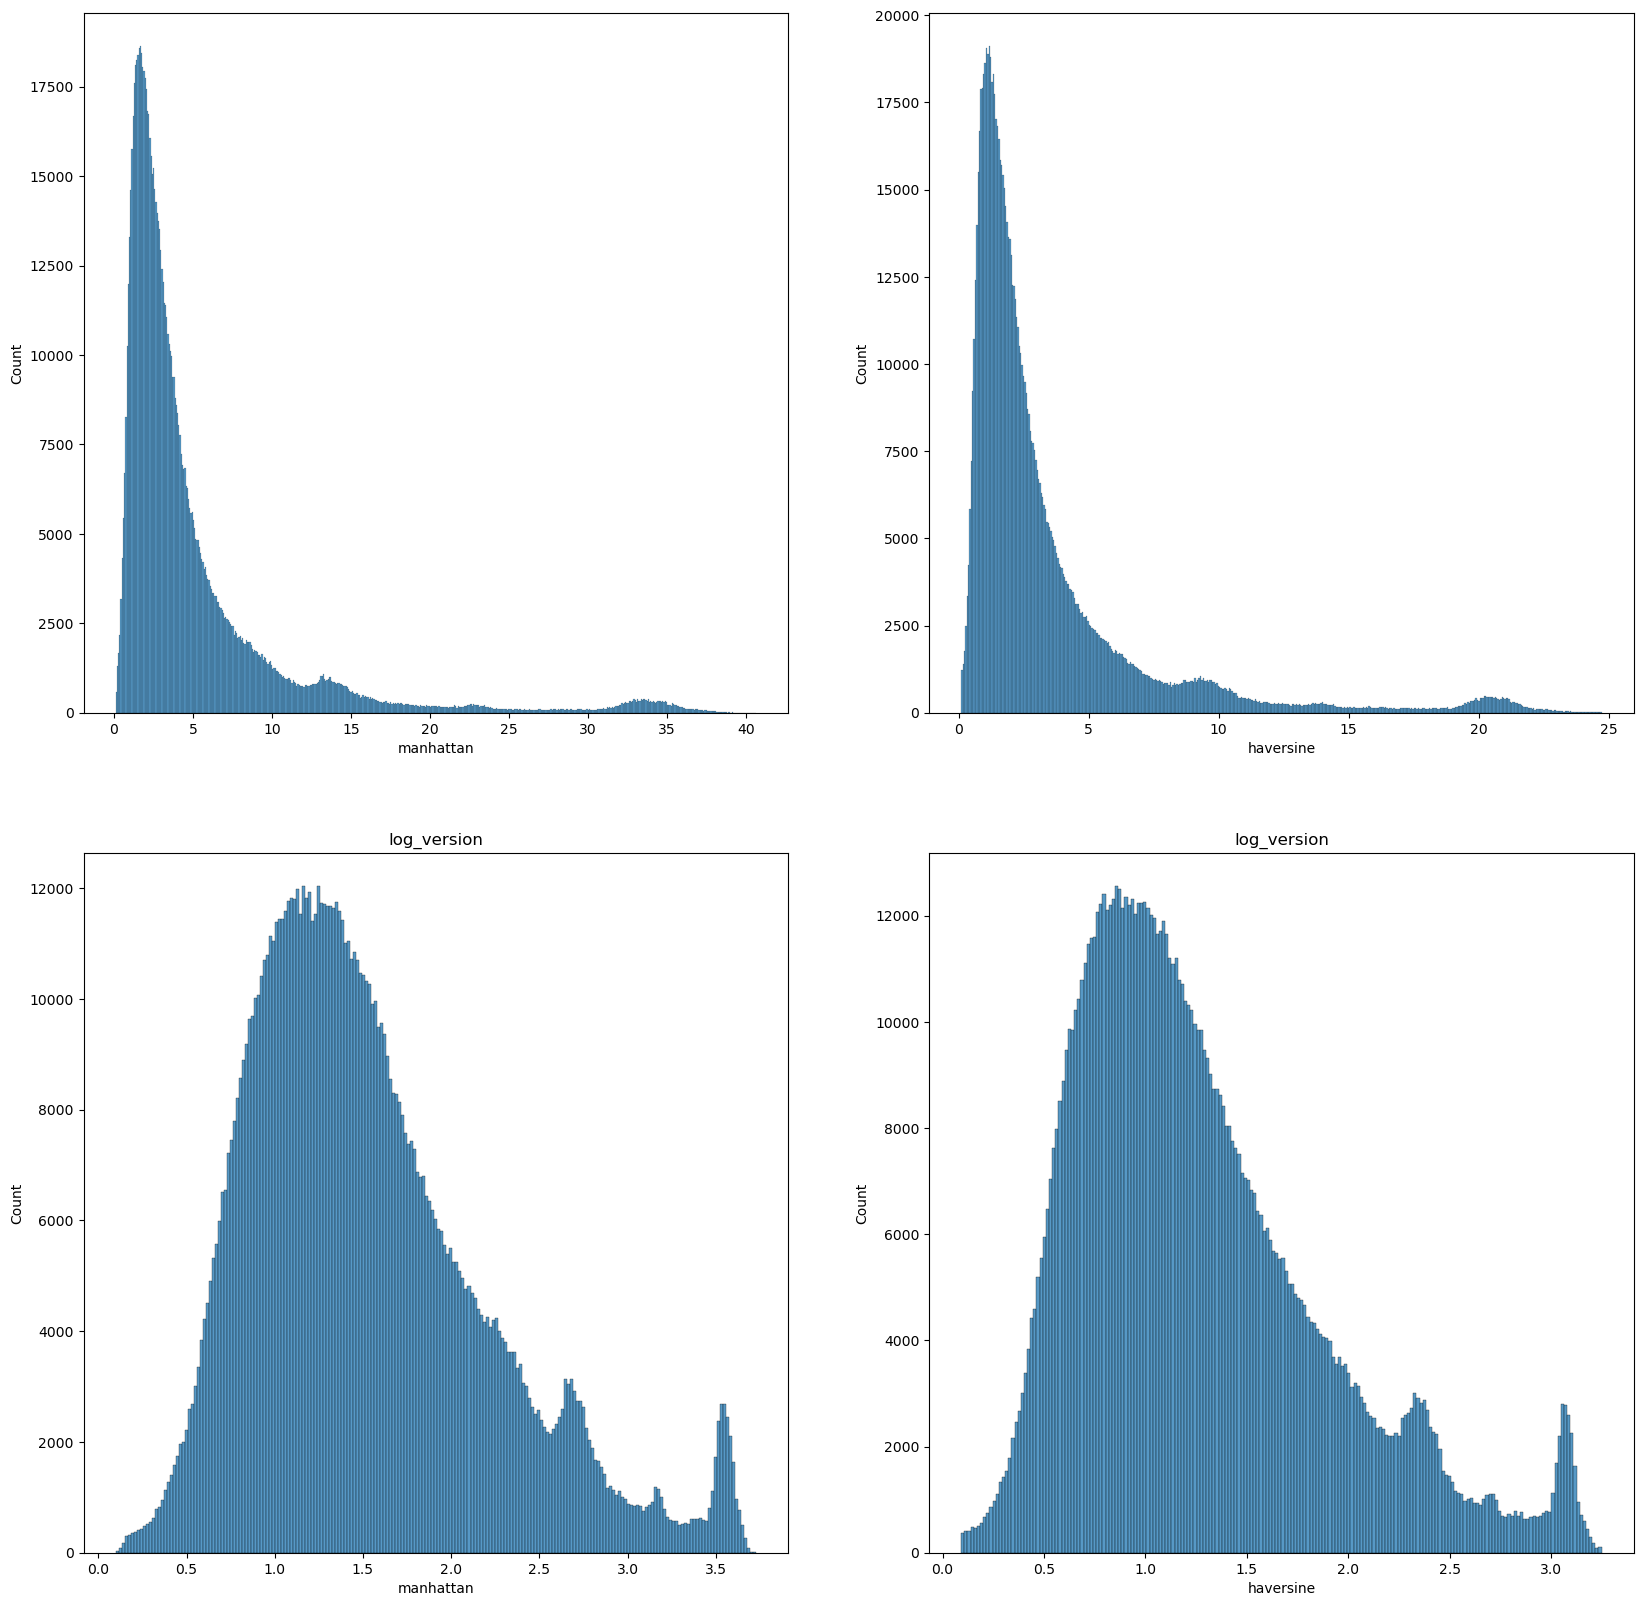

In [1279]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.histplot(df['manhattan'])

plt.subplot(2, 2, 2)
sns.histplot(df['haversine'])

plt.subplot(2, 2, 3)
sns.histplot(np.log1p(df['manhattan']))
plt.title('log_version')

plt.subplot(2, 2, 4)
sns.histplot(np.log1p(df['haversine']))
plt.title('log_version')

plt.show()

### Аналогично для таргета

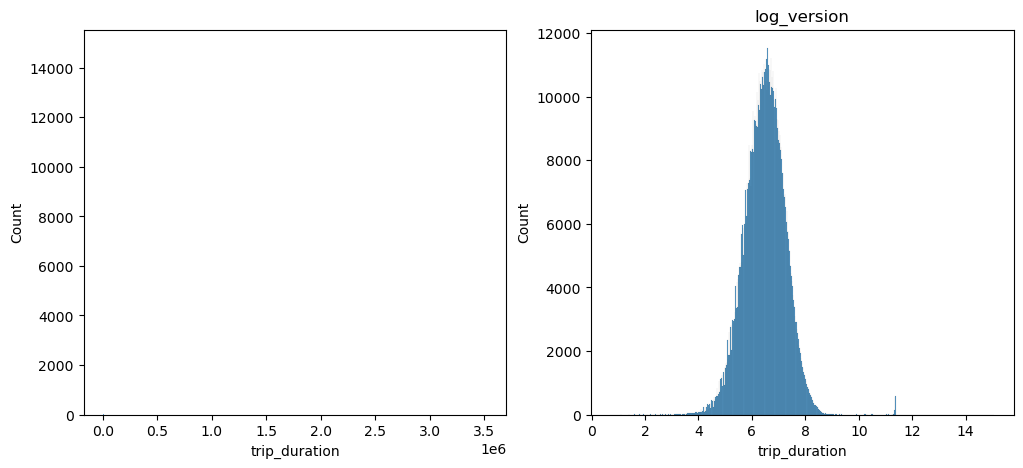

In [1281]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['trip_duration'])

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['trip_duration']))
plt.title('log_version')

plt.show()

In [1282]:
q3 = df['trip_duration'].quantile(0.998)
df = df[df['trip_duration'] <= q3]

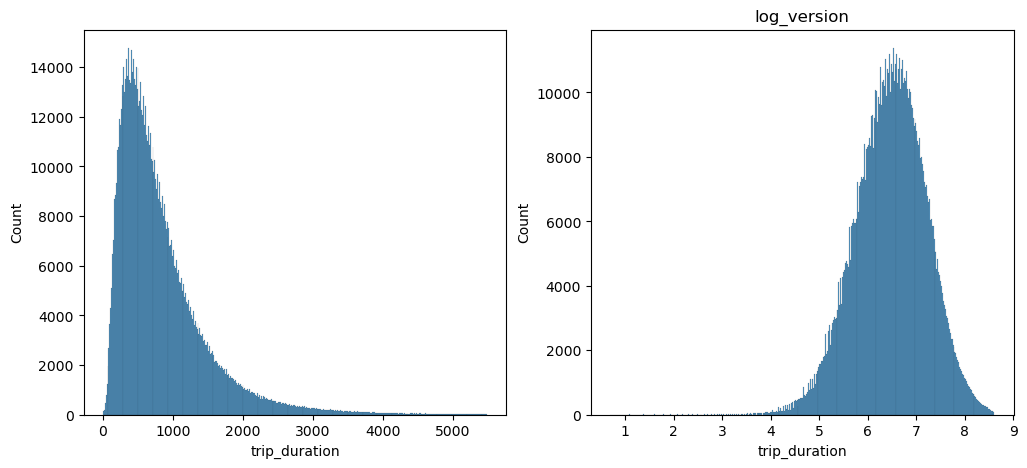

In [1283]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['trip_duration'])

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['trip_duration']))
plt.title('log_version')
plt.show()

### Смотрим изменение корреляции

<Axes: >

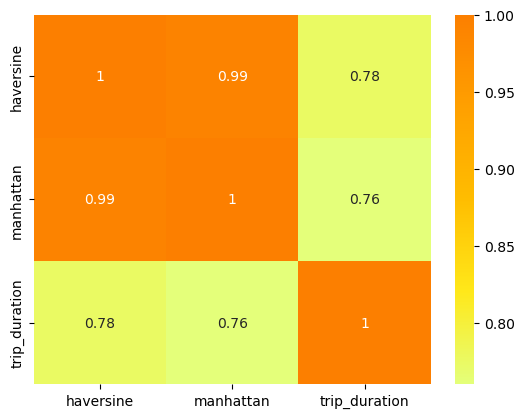

In [1285]:
corr_matrix = df[['haversine', 'manhattan', 'trip_duration']].corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='Wistia', annot=True)

### Корреляция с расстоянием сильно улучшилась!

# ЛОГАРИФМИРУЕМ

In [1299]:
df['manhattan'] = df['manhattan'].apply(lambda var: np.log1p(var))
df['haversine'] = df['haversine'].apply(lambda var: np.log1p(var))

# РАЗДЕЛЯЕМ НА ФИЧИ И ТАРГЕТ

In [1301]:
y = df['trip_duration']
df = df.drop(columns=['trip_duration'])

# ОБУЧАЕМ С ОБЫЧНОЙ МОДЕЛЬЮ И СМОТРИМ СКОР ПРИ РАЗНЫХ ФИЧАХ

In [1523]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Смотрим, будет лучше с обоими расстояниями или только одним

In [1525]:
model = LinearRegression()

### Только Манхэттэнское

In [1527]:
df_m = df['manhattan']
X_train, X_test, y_train, y_test = train_test_split(df_m.to_frame(), y, test_size = 0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

427.0276946455339

### Только Хаверсин

In [1529]:
df_h = df['haversine']
X_train, X_test, y_train, y_test = train_test_split(df_h.to_frame(), y, test_size = 0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.3372793163975

### Оба расстояния

In [1531]:
df_both = df[['haversine', 'manhattan']]
X_train, X_test, y_train, y_test = train_test_split(df_both, y, test_size = 0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.60643090389766

### Как видим, чисто с Хаверсином ситуация чуть лучше, Манхэттэнское расстояние больше не учитываем. Теперь будем смотреть с пассажирами

In [1533]:
df_nondates1 = df[['haversine', 'passenger_count']]

In [1534]:
df_nondates1.head()

,haversine,passenger_count
0,0.816774,2
1,1.758549,1
2,2.136659,1
3,1.491750,1
4,1.247338,1


In [1535]:
ct = ColumnTransformer([
    ('prscaler', StandardScaler(), ['haversine']),
    ('minmaxscaler', MinMaxScaler(), ['passenger_count'])
])

In [1536]:
X_train, X_test, y_train, y_test = train_test_split(df_nondates1, y, test_size = 0.3, random_state=42)

In [1537]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1538]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.3468073774148

### Хуже! Отбрасываем пассажиров, добавляем перевозчика

In [1540]:
df_nondates2 = df[['haversine', 'vendor_id']]

In [1541]:
df_nondates2.head()

,haversine,vendor_id
0,0.816774,2
1,1.758549,1
2,2.136659,1
3,1.491750,2
4,1.247338,1


In [1542]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['vendor_id']),
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1543]:
X_train, X_test, y_train, y_test = train_test_split(df_nondates2, y, test_size = 0.3, random_state=42)

In [1544]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1545]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.3340328831117

### Качественного прироста нет, убираем. То же самое, но добавляем флажок

In [1547]:
df_nondates3 = df[['haversine', 'store_and_fwd_flag']]

In [1548]:
df_nondates3.head()

,haversine,store_and_fwd_flag
0,0.816774,N
1,1.758549,N
2,2.136659,N
3,1.491750,N
4,1.247338,N


In [1549]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['store_and_fwd_flag']),
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1550]:
X_train, X_test, y_train, y_test = train_test_split(df_nondates3, y, test_size = 0.3, random_state=42)

In [1551]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1552]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.32610245141313

### Аналогично, не используем. Пробуем с датами, сравниваем с их категориальным вариантом

In [1554]:
df_dates1 = df[['haversine', 'month', 'dow', 'hour']]

In [1555]:
df_dates1.head()

,haversine,month,dow,hour
0,0.816774,5,1,9
1,1.758549,1,4,16
2,2.136659,4,6,13
3,1.491750,1,6,17
4,1.247338,2,3,17


In [1556]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['month', 'dow', 'hour']),
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1557]:
X_train, X_test, y_train, y_test = train_test_split(df_dates1, y, test_size = 0.3, random_state=42)

In [1558]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1559]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

403.7466017572876

In [1560]:
df_dates2 = df[['haversine', 'morning', 'day', 'evening', 'night', 'corner_days',	'middle_days',	'weekends']]

In [1561]:
df_dates2.head()

,haversine,morning,day,evening,night,corner_days,middle_days,weekends
0,0.816774,1,0,0,0,0,1,0
1,1.758549,0,1,0,0,1,0,0
2,2.136659,0,1,0,0,0,0,1
3,1.491750,0,1,0,0,0,0,1
4,1.247338,0,1,0,0,0,1,0


In [1562]:
ct = ColumnTransformer([
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1563]:
X_train, X_test, y_train, y_test = train_test_split(df_dates2, y, test_size = 0.3, random_state=42)

In [1564]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1565]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

424.3372793163975

### Используем ванхот для чисел в датах вместо категориальных признаков. К датам добавляем популярный маршрут

In [1567]:
df_pop = df[['haversine', 'month', 'dow', 'hour', 'popular_route']]

In [1568]:
df_pop.head()

,haversine,month,dow,hour,popular_route
0,0.816774,5,1,9,1
1,1.758549,1,4,16,1
2,2.136659,4,6,13,0
3,1.491750,1,6,17,1
4,1.247338,2,3,17,1


In [1569]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['month', 'dow', 'hour']),
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1570]:
X_train, X_test, y_train, y_test = train_test_split(df_pop, y, test_size = 0.3, random_state=42)

In [1571]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1572]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

403.7466017572876

### Прироста нет... Возьмём просто клетки

In [1574]:
df_cells = df[['haversine', 'month', 'dow', 'hour', 'pickup_cell', 'dropoff_cell']]

In [1575]:
df_cells.head()

,haversine,month,dow,hour,pickup_cell,dropoff_cell
0,0.816774,5,1,9,5,5
1,1.758549,1,4,16,5,5
2,2.136659,4,6,13,5,6
3,1.491750,1,6,17,5,5
4,1.247338,2,3,17,5,5


In [1576]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['month', 'dow', 'hour', 'pickup_cell', 'dropoff_cell']),
    ('prscaler', StandardScaler(), ['haversine'])
])

In [1577]:
X_train, X_test, y_train, y_test = train_test_split(df_cells, y, test_size = 0.3, random_state=42)

In [1578]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [1579]:
model.fit(X_train, np.log1p(y_train))
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

363.71927605889715

### А вот и победитель!

# РЕГУЛЯРИЗАЦИЯ

In [1582]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

### Lasso

In [1584]:
lasso = Lasso()

In [1585]:
alphas = np.linspace(0.1, 10, 10)
param_grid = {'alpha': alphas}

In [1586]:
grid_search = GridSearchCV(estimator=lasso,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])},
             scoring='neg_root_mean_squared_error')

In [1587]:
params = grid_search.best_params_
params

{'alpha': 0.1}

In [1588]:
lasso = Lasso(**params)

In [1589]:
lasso.fit(X_train, np.log1p(y_train))
y_pred_log = lasso.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

410.7576771224153

### Ridge

In [1591]:
ridge = Ridge()

In [1592]:
alphas = np.linspace(0.1, 10, 20)
param_grid = {'alpha': alphas}

In [1593]:
grid_search = GridSearchCV(estimator=ridge,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])},
             scoring='neg_root_mean_squared_error')

In [1594]:
params = grid_search.best_params_
params

{'alpha': 1.142105263157895}

In [1595]:
ridge = Ridge(**params)

In [1596]:
ridge.fit(X_train, np.log1p(y_train))
y_pred_log = ridge.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
root_mean_squared_error(y_test, y_pred)

363.721115867713

### Опять же, качественного прироста нет, не используем

# ПРЕДСКАЗЫВАЕМ ПО test.csv

In [1599]:
df_valid = pd.read_csv('./new_data/test.csv')

In [1600]:
ids = df_valid['id']
df_valid = df_valid.drop(columns=['id'])

In [1601]:
df_valid['pickup_cell'] = df_valid.apply(lambda row: calc_cell(row.pickup_longitude, row.pickup_latitude), axis=1)
df_valid['dropoff_cell'] = df_valid.apply(lambda row: calc_cell(row.dropoff_longitude, row.dropoff_latitude), axis=1)

In [1602]:
# Добавляем месяц
df_valid['month'] = df_valid['pickup_datetime'].str[5:7].astype(int)
# Добавляем день недели
df_valid['dow'] = df_valid['pickup_datetime'].apply(lambda timestamp: datetime.date(day=int(timestamp[8:10]), month=int(timestamp[5:7]), year=int(timestamp[:4])).weekday())
# Добавляем час
df_valid['hour'] = df_valid['pickup_datetime'].str[10:13].astype(int)

In [1603]:
# Считаем Хаверсин
def calc_haversine(lat1, lat2, lon1, lon2):
    R = 6371e3;
    phi1 = lat1 * math.pi/180;
    phi2 = lat2 * math.pi/180;
    dphi = (lat2-lat1) * math.pi/180;
    dlam = (lon2-lon1) * math.pi/180;

    a = math.sin(dphi/2) * math.sin(dphi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(dlam/2) * math.sin(dlam/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));

    return (R * c)/1000
df_valid['haversine'] = df_valid.apply(lambda row: calc_haversine(row.pickup_latitude, row.dropoff_latitude, row.pickup_longitude, row.dropoff_longitude), axis=1)

# Убираем использованное
df_valid = df_valid.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

# Логарифмируем Хаверсин
df_valid['haversine'] = df_valid['haversine'].apply(lambda var: np.log1p(var))

In [1604]:
# Убираем мусорные признаки
df_valid = df_valid.drop(columns=['passenger_count', 'store_and_fwd_flag', 'vendor_id'])

In [1605]:
df_valid.head()

,pickup_cell,dropoff_cell,month,dow,hour,haversine
0,5,5,6,2,7,1.325230
1,5,5,4,6,12,1.084912
2,5,5,6,6,2,0.877455
3,5,5,5,3,17,1.091473
4,3,5,5,3,17,3.083640


In [1606]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['month', 'dow', 'hour', 'pickup_cell', 'dropoff_cell']),
    ('prscaler', StandardScaler(), ['haversine'])
])

X = ct.fit_transform(df_valid)
y_pred_log = model.predict(X)
y_pred = np.exp(y_pred_log) - 1

In [1607]:
df_final = pd.DataFrame({
    'id': ids,
    'trip_duration':y_pred
})

In [1608]:
df_final.to_csv('output.csv', index=False)